# Titanic Classification

The objective of this homework is to practice simple decision trees. To successfully complete this homework, you may use any resources available to you. 

Get the `titanic3.csv` data (Source: [Link](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt)).

1. Analyze the data using pandas.
    * Create a column that specifies whether the person is a child (age <= 10)
    * Group the data by `sex`, `child`, `pclass` and interpret the survival rate.
2. Develop a decision tree with depth of 1.
    * Preprocess the `sex` column using LabelEncoder
    * Develop the decision tree
    * Visually reproduce the decision tree using a seaborn barchart.
    * Use the t-test from scipy.stats to statistically reproduce the decision.
    * Interpret the decision tree.
3. Develop a decision tree with depth of 2.
    * Develop the decision tree
    * Visually reproduce the decision tree using seaborn barcharts (left side and right side)
    * Use the ranksums test from scipy.stats to statistically reproduce the decisions.
    * Interpret the decision tree. 
    
Hints:
* Explain what you are doing.
* Use references.

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns


In [52]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.metrics as sm

In [53]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [54]:
%matplotlib inline

In [55]:
tc = pd.read_csv("https://raw.githubusercontent.com/mschermann/msis2802winter2018homework/master/\
titanic3.csv")

In [56]:
tc.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

## Description of the dataset

Each row is a passenger on the Titanic. The columns report attributes for the passengers:

| Column | Description | Relevant for this homework|
|--------|-------------|--------|
|`survived`|1 = survived, 0 = died | **X**|
|`pclass`| 1 = first class, 2 = second class, 3 = third class |**X**|
|`name`| Name of the passenger| |
|`sex`| male or female|**X**|
|`age`| age in years|**X**|
|`sibsp`| The number of siblings or spouses that are also traveling on the Titanic| |
|`parch`| The number of parents or childen that are also traveling on the Titanic| |
|`ticket`|The ticket number| |
|`fare`| The ticket price | |
|`cabin`| The cabin number | |
|`embarked`| The starting city | |
|`boat`| The emergency boat number | |
|`body`| The identification number of the body | |
|`home.dest`| The destination of the passenger | |

## Women and children first?

### Create a column that specifies whether the person is a child (10 years or younger)


In [57]:
tc.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [58]:
# dumminize the column into 0 and 1 based on age 
tc['child']=tc.apply(lambda x: 1 if x['age']<=10 else 0, axis=1)
tc['child'].head()

0    0
1    1
2    1
3    0
4    0
Name: child, dtype: int64

### Group the data by `sex`, `child`, `pclass` and interpret the survival rate.

In [59]:
# because the survived column is 0 and 1, the mean of the column is the survival rate
tc.groupby(['sex','child','pclass'])['survived'].mean()

sex     child  pclass
female  0      1.0       0.972028
               2.0       0.873684
               3.0       0.491979
        1      1.0       0.000000
               2.0       1.000000
               3.0       0.482759
male    0      1.0       0.329545
               2.0       0.087500
               3.0       0.138528
        1      1.0       1.000000
               2.0       1.000000
               3.0       0.354839
Name: survived, dtype: float64

Female girls from the first class have 0 survival rate. This looks suspicious to me, so I double checked and found there was only one girl in this class and she didn't make it.

In [98]:
tc[(tc['pclass']==1)&(tc['child']==1)&(tc['sex']=='female')]['survived']

2    0.0
Name: survived, dtype: float64

Female girls from the second class all survived.

In [99]:
tc[(tc['pclass']==2)&(tc['child']==1)&(tc['sex']=='female')]['survived']

340    1.0
377    1.0
430    1.0
434    1.0
478    1.0
479    1.0
540    1.0
541    1.0
588    1.0
590    1.0
591    1.0
Name: survived, dtype: float64

Male boys from both the first and the second class all survived. Besides these extreme rates, female adults from the first class have the highest surviral rate, which was expected. And females in gerneral, both children and adults, have higher surviral rates than males. Childrens in gerneral have higher surviral rates than adults. Male adults from the second class have the lowest surviral rate (not comparing to 0 serviral rate here). Possible reasons could be these men (could be those pastors and band members) had higher moral standard than men from the third group and voluntarily give up the right to others. They were also not as rich as the first class and probably didn't have stronger sense of resposibility to sustain family legacy. 

## Decision Tree with depth of 1

### Restrict your analysis on the relevant columns (check table above).

In [60]:
# slice out the relavent data
data=tc[['survived','pclass','sex','child']]

### Preprocess the `sex` column

In [101]:
import warnings
warnings.filterwarnings('ignore')
data.dropna(inplace=True, how='any')

In [102]:
# double check 
data.isnull().sum()

survived    0
pclass      0
sex         0
child       0
dtype: int64

In [103]:
# change sex to a dummy variable
le_sex = pp.LabelEncoder()
data['sex'] = le_sex.fit_transform(data['sex'].astype(str))
data['sex'].head()

0    0
1    1
2    0
3    1
4    0
Name: sex, dtype: int64

### Clean the dataset

In [64]:
# define my X and y
X = data.drop(['survived'],axis=1)
y = data['survived']

### Build the decision tree

**Build** and **visualize** a decision tree with depth of 1 (i.e., one root and two leaf nodes) to find differences between passengers who survived and those who did not. 

In [65]:
dt = tree.DecisionTreeClassifier(max_depth=1)

In [66]:
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

You need to adapt the `XXX` in the following code to visualize the decision tree.

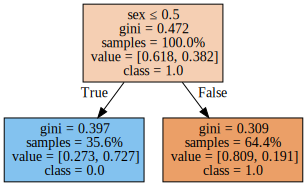

In [74]:
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(X.columns),  
                         class_names = ['0.0' if i == 1 else '1.0' for i in dt.classes_] ,
                         filled=True, 
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph 

### Visually reproduce the decision tree using a seaborn factorplot.


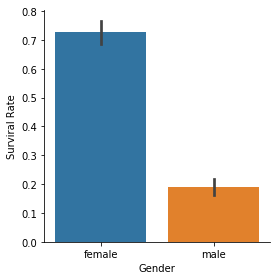

In [109]:
sex= sns.factorplot(x='sex',y='survived', data=tc, kind='bar')
sex.set_axis_labels(x_var='Gender', y_var='Surviral Rate');

### Use the t-test from `scipy.stats` to statistically reproduce the decision.

In [71]:
from scipy.stats import ttest_ind

In [73]:
# perform t test on sex over surviral
ttest_ind(data[data['survived']==1]['sex'], data[data['survived']==0]['sex'])

Ttest_indResult(statistic=-22.517977185525755, pvalue=3.7758923579444459e-95)

p valus is less than 0.05, which means sex have a significant influence on surviral rate.

## Develop a decision tree with depth of 2

<b>Build</b> and <b>show</b> a decision tree of <b>depth = 2</b> to find the differences between those who survived and those who didn't. Your tree should have four leaves.

In [75]:
dt2 = tree.DecisionTreeClassifier(max_depth=2)

In [76]:
dt2.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

You need to adapt the `XXX` in the following code to visualize the decision tree.

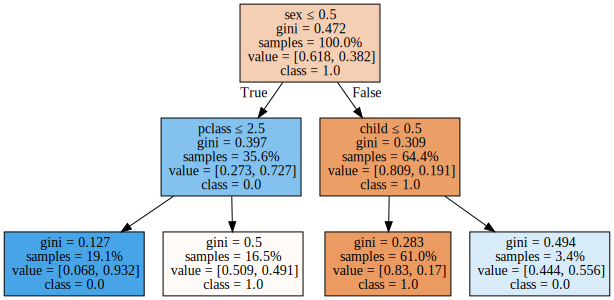

In [77]:
import graphviz
dot_data = tree.export_graphviz(dt2, out_file=None, 
                         feature_names=list(X.columns),  
                         class_names = ['0.0' if i == 1 else '1.0' for i in dt.classes_] ,
                         filled=True, 
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph 

###  Visually reproduce the left side of the decision tree using seaborn barcharts

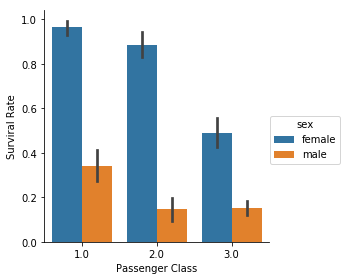

In [108]:
classes = sns.factorplot(x='pclass',y='survived', data=tc, kind='bar', hue='sex')
classes.set_axis_labels(x_var='Passenger Class', y_var='Surviral Rate');

### Use the ranksums test from scipy.stats to statistically reproduce the decision on the left side.


In [82]:
from scipy.stats import f_oneway, ranksums

In [86]:
# slice out the female set
female = data[data['sex']==0]

In [87]:
ranksums(female['pclass'],female['survived'])

RanksumsResult(statistic=20.484303963307045, pvalue=2.9720138393538342e-93)

p value is less than 0.05, which implies among all females, means of surviral rate are significantly different between different classes. 

###  Visually reproduce the right side of the decision tree using seaborn barcharts

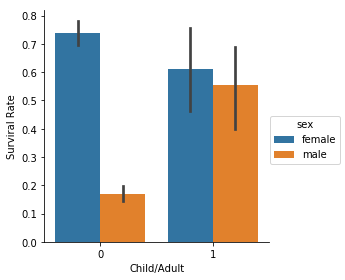

In [115]:
children = sns.factorplot(x='child',y='survived', data=tc, kind='bar', hue='sex')
children.set_axis_labels(x_var='Child/Adult', y_var='Surviral Rate');
# 0 is adult and 1 is child

### Use the ranksums test from scipy.stats to statistically reproduce the decisions on the right side.


In [93]:
male = data[data['sex']==1]

In [104]:
ranksums(male['child'],male['survived'])

RanksumsResult(statistic=-4.8917141998163833, pvalue=9.9961526021571029e-07)

p value is less than 0.05, which implies among all males, means of surviral rate are significantly different between children and adults. 

# Reference

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_ind.html

https://stackoverflow.com/questions/22611446/perform-2-sample-t-test

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ranksums.html

https://www.programcreek.com/python/example/100338/scipy.stats.ranksums

